In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from bokeh.plotting import figure, show, output_notebook
import IPython

output_notebook()

from pylab import *
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 20.0) # set default size of plots
import time

Loading BokehJS ...

## Data Read

In [2]:
train_dir = "../input"
train_file = "train.csv"

fbcheckin_train_tbl = pd.read_csv(os.path.join(train_dir, train_file))

In [3]:
# Sort by place_id
fbcheckin_train_tbl = fbcheckin_train_tbl.sort_values(by="place_id")

In [4]:
num_train = len(fbcheckin_train_tbl)
print "Train samples: {}".format(num_train)
print "Unique places: {}".format(fbcheckin_train_tbl.place_id.unique().size)
print "Avg samples per places: {}".format(num_train/float(fbcheckin_train_tbl.place_id.unique().size))

Train samples: 29118021
Unique places: 108390
Avg samples per places: 268.641212289


In [5]:
fbcheckin_train_stats_df = fbcheckin_train_tbl.describe()
fbcheckin_train_stats_df

,row_id,x,y,accuracy,time,place_id
count,2.911802e+07,2.911802e+07,2.911802e+07,2.911802e+07,2.911802e+07,2.911802e+07
mean,1.455901e+07,4.999770e+00,5.001814e+00,8.284912e+01,4.170104e+05,5.493787e+09
std,8.405649e+06,2.857601e+00,2.887505e+00,1.147518e+02,2.311761e+05,2.611088e+09
min,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000016e+09
25%,7.279505e+06,2.534700e+00,2.496700e+00,2.700000e+01,2.030570e+05,3.222911e+09
50%,1.455901e+07,5.009100e+00,4.988300e+00,6.200000e+01,4.339220e+05,5.518573e+09
75%,2.183852e+07,7.461400e+00,7.510300e+00,7.500000e+01,6.204910e+05,7.764307e+09
max,2.911802e+07,1.000000e+01,1.000000e+01,1.033000e+03,7.862390e+05,9.999932e+09


In [10]:
tr_x_min, tr_x_max = fbcheckin_train_stats_df["x"]["min"], fbcheckin_train_stats_df["x"]["max"]
tr_y_min, tr_y_max = fbcheckin_train_stats_df["y"]["min"], fbcheckin_train_stats_df["y"]["max"]
tr_time_min, tr_time_max = fbcheckin_train_stats_df["time"]["min"], fbcheckin_train_stats_df["time"]["max"]
tr_place_id_min, tr_place_id_max = fbcheckin_train_stats_df["place_id"]["min"], fbcheckin_train_stats_df["place_id"]["max"]
tr_acc_min, tr_acc_max = fbcheckin_train_stats_df["accuracy"]["min"], fbcheckin_train_stats_df["accuracy"]["max"]

## Data Visualization

In [6]:
# Sort by place_id
fbcheckin_train_tbl = fbcheckin_train_tbl.sort_values(by="place_id")

# Take few samples for visualization
sample_fbcheckin_train_tbl = fbcheckin_train_tbl[:10000].copy()

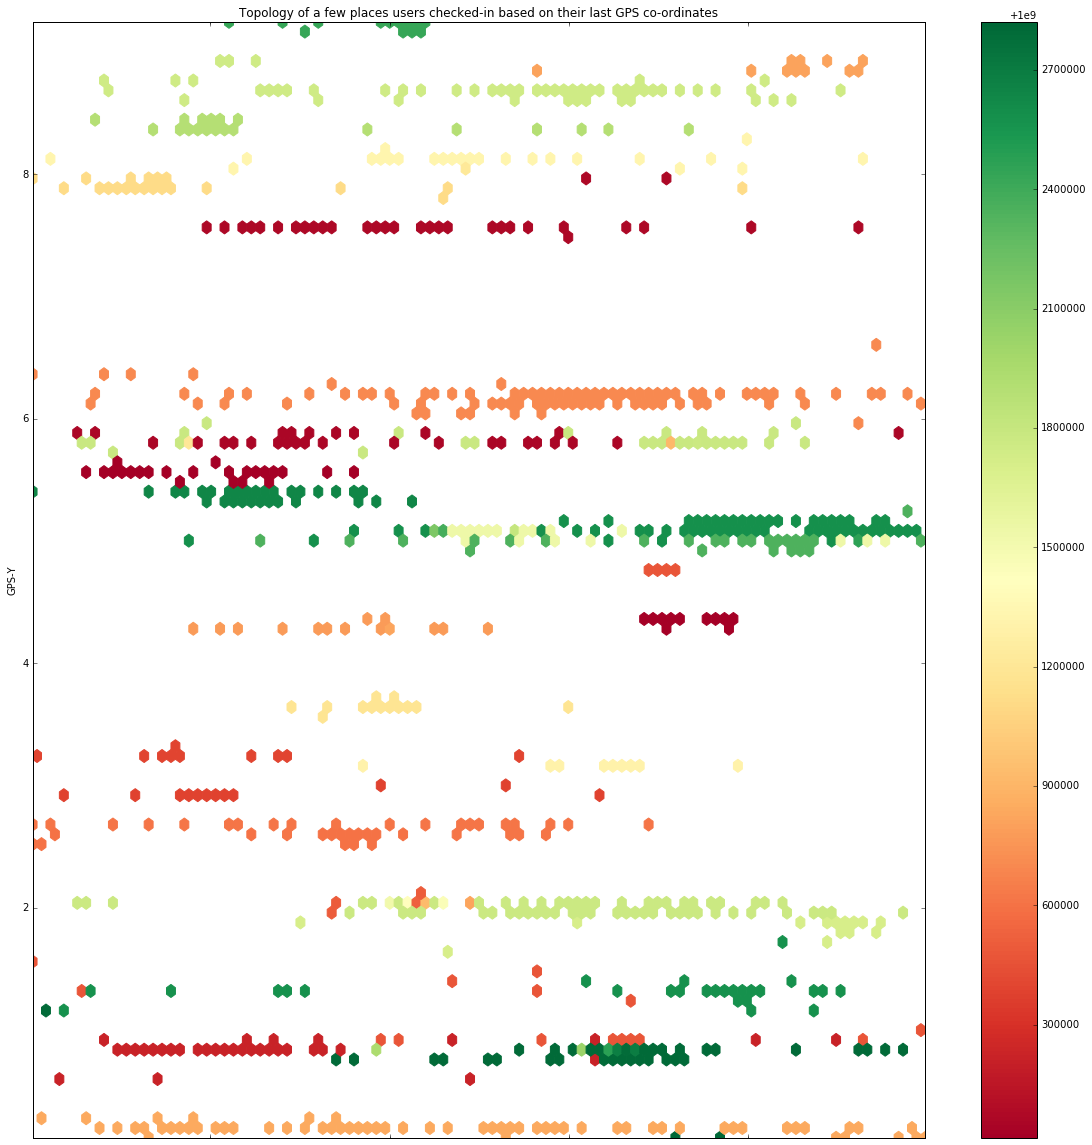

In [7]:
ax = sample_fbcheckin_train_tbl.plot(kind='hexbin', x='x', y='y', C='place_id', colormap='RdYlGn')
ax.set_xlabel("GPS-X")
ax.set_ylabel("GPS-Y")
ax.set_title("Topology of a few places users checked-in based on their last GPS co-ordinates")

## Some Analysis

This is interesting. In this plot, each color represents a unique business place. Individual hexagon represents last known GPS co-ordinates of users who checked into these places. As we can see from the statistics above, variance of the GPS-X and GPS-Y over all samples is nearly similar, std=2.857601e+00 for X and std=2.887505e+00 for Y. However, if we look at the distribution of user's GPS co-ordinates associated with place_id, we see that these co-ordinates are more scattered over X than Y. For some places they span the whole X range! We can infer that either the dataset (more precisely what we sampled) consist of places which are located very close to each other or the large variance is due to inaccurate GPS locations; we should check accuracies of all these points.

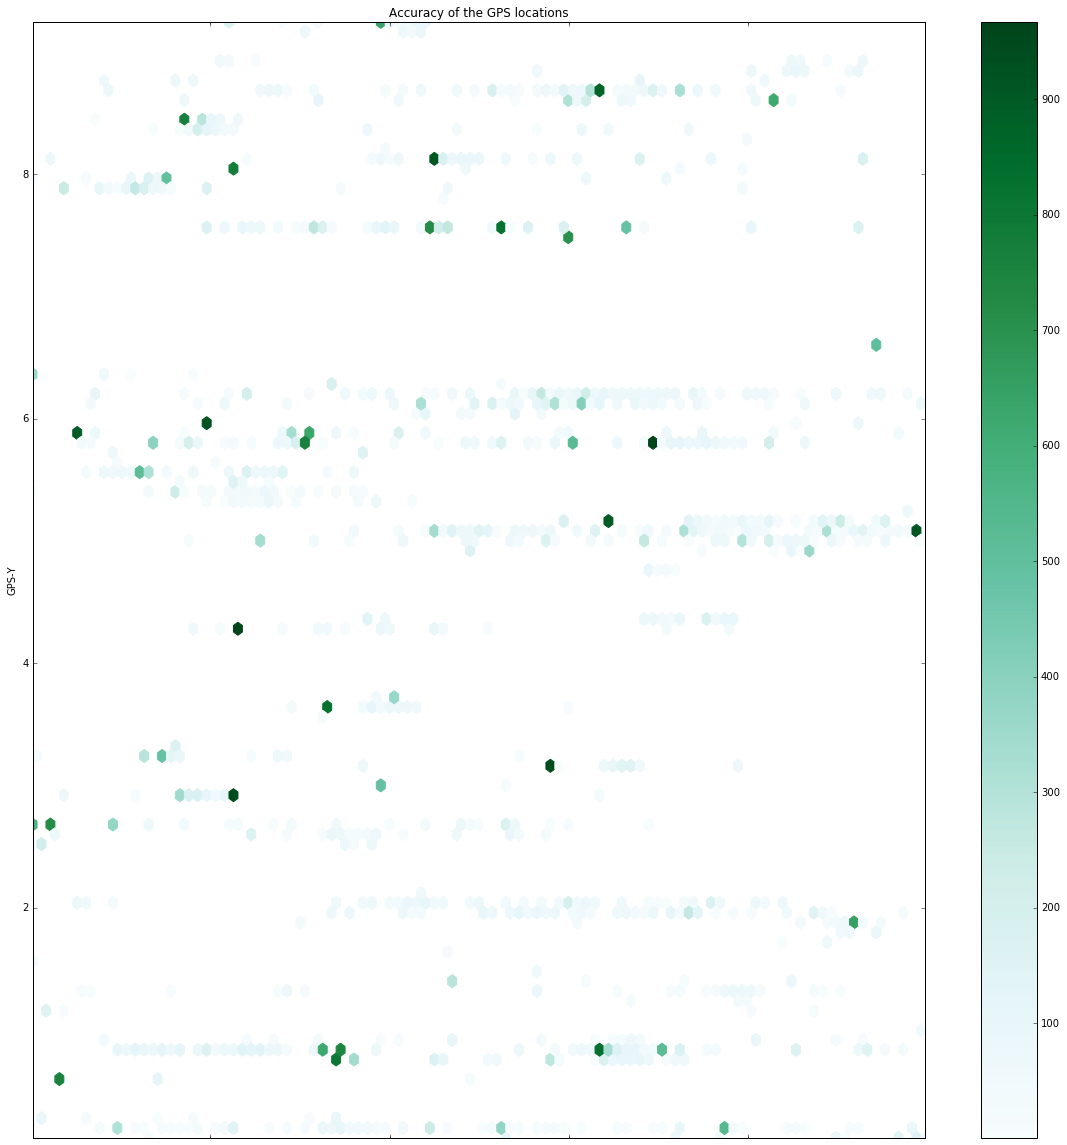

In [8]:
ax = sample_fbcheckin_train_tbl.plot(kind='hexbin', x='x', y='y', C='accuracy')
ax.set_xlabel("GPS-X")
ax.set_ylabel("GPS-Y")
ax.set_title("Accuracy of the GPS locations")

From this plot, we can observe that many of the locations have low to medium accuracies. Our data should speak the same. Let's validate this.

In [11]:
print("Locations with accuracy above average: {}%".format(
        sum(sample_fbcheckin_train_tbl["accuracy"] > (tr_acc_max-tr_acc_min)/2.0)*100/float(
                                                                        sample_fbcheckin_train_tbl.shape[0])))

Locations with accuracy above average: 1.51%


Only 1.51% of the locations have acuracy above average. Let's take one of the business locations and try to visualize accuracy spread of the user's locations who visited it. 

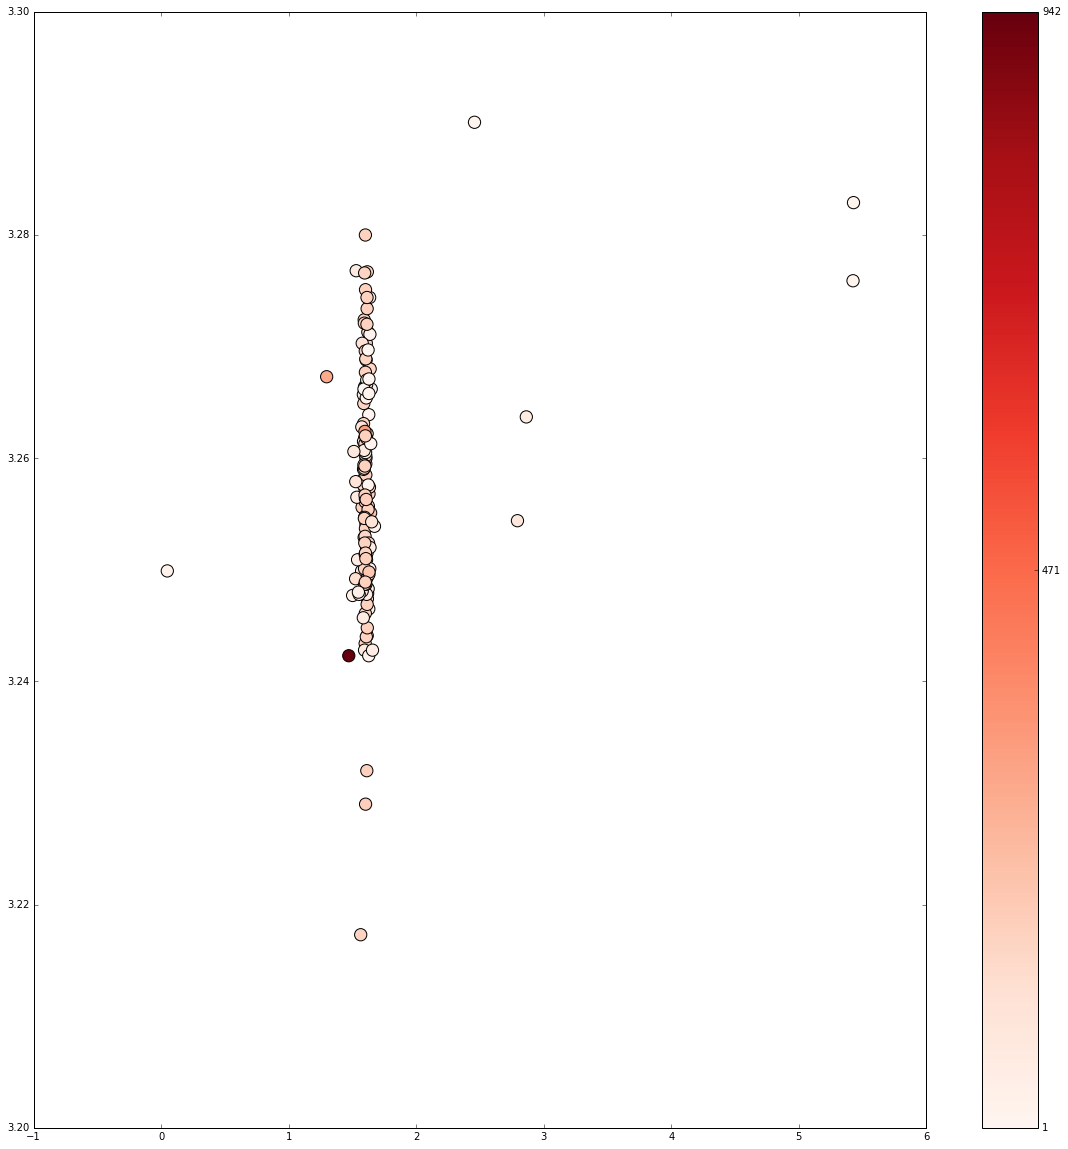

In [12]:
place_id = sample_fbcheckin_train_tbl.place_id.unique()[7]
df_place = fbcheckin_train_tbl[fbcheckin_train_tbl["place_id"]==place_id]

fig, ax = plt.subplots()
cax = plt.scatter(df_place["x"], df_place["y"], c=df_place["accuracy"], s=150.0, cmap=plt.cm.Reds)
cbar = fig.colorbar(cax, ticks=[df_place["accuracy"].min(), 
                        (df_place["accuracy"].max()+df_place["accuracy"].min())/2, df_place["accuracy"].max()])

At first, it might seem that locations are spread out in y. However, if we look carefully we see that the Y axis scale is very small compared to the X axis. We can find the same thing from their statistics: 

In [13]:
print("X min:{}, max:{}, var:{}".format(df_place["x"].min(), df_place["x"].max(), df_place["x"].var()))
print("Y min:{}, max:{}, var:{}".format(df_place["y"].min(), df_place["y"].max(), df_place["y"].var()))

X min:0.0485, max:5.4286, var:0.26711699061
Y min:3.2173, max:3.2901, var:0.000116940437196


Clearly locations are more spread out in X, and as found earlier, sometimes they even span the whole X range. Based on these findings, we can guess that the people are mostly coming from left or right side of this mini palces map or the roads are planned in such a way.

Now, to find out the actual location of the place the easiest approach would be to take the mean value. To get more precise estimate we should take the weighted average of the locations with weights being the accuracy of the location. This way we give more importance to locations reported with high accuracy that the lower ones. Let's check the difference. 

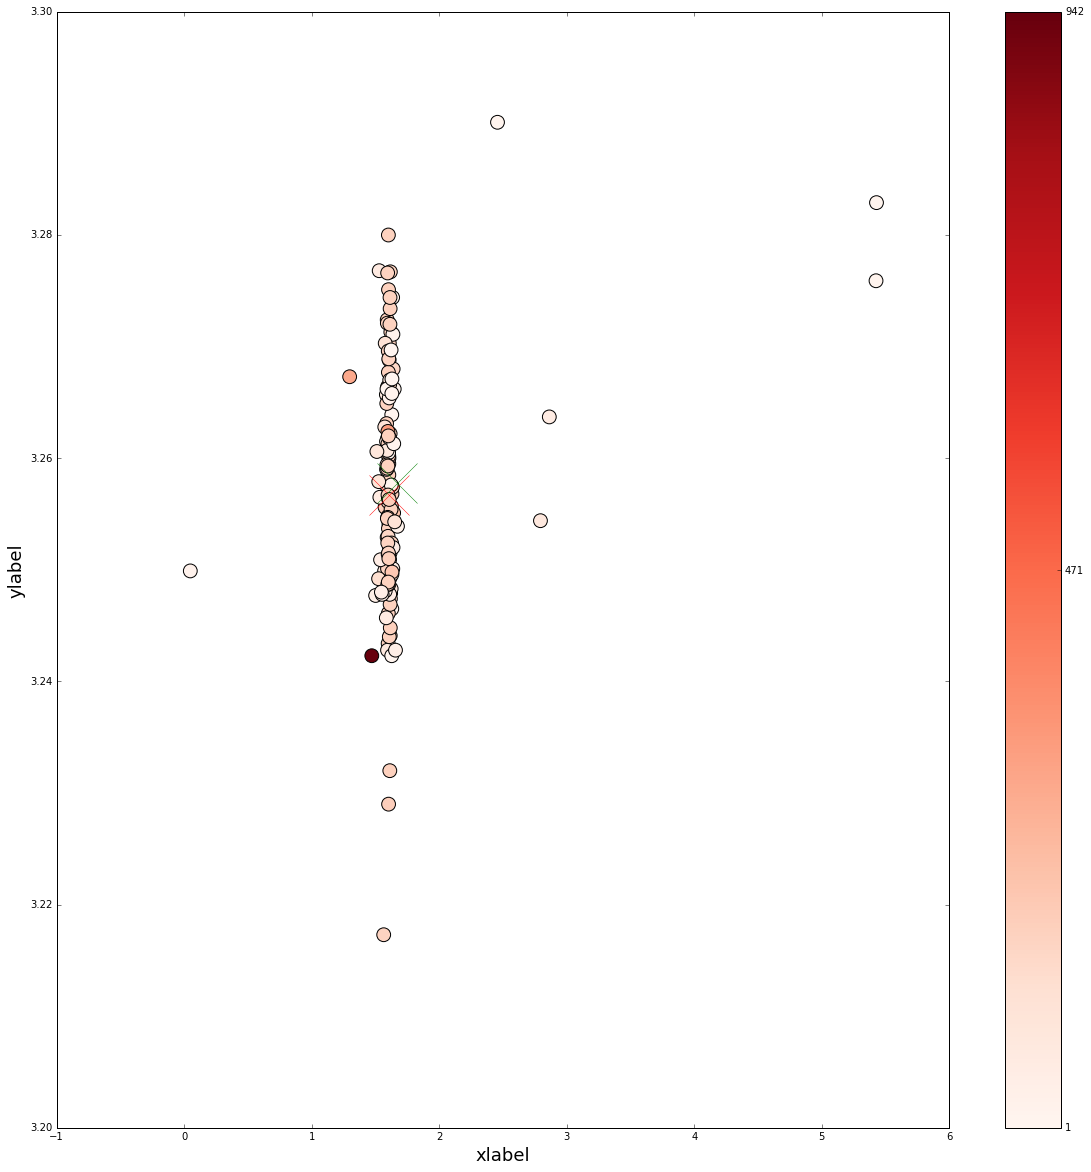

In [14]:
place_id = sample_fbcheckin_train_tbl.place_id.unique()[7]
df_place = fbcheckin_train_tbl[fbcheckin_train_tbl["place_id"]==place_id]

x_wt = df_place["accuracy"]*df_place["x"]
x_wt_mean = x_wt.sum()/float(sum(df_place["accuracy"]))

y_wt = df_place["accuracy"]*df_place["y"]
y_wt_mean = y_wt.sum()/float(sum(df_place["accuracy"]))

fig, ax = plt.subplots()
cax = plt.scatter(df_place["x"], df_place["y"], c=df_place["accuracy"], s=190.0, cmap=plt.cm.Reds)
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
cbar = fig.colorbar(cax, ticks=[df_place["accuracy"].min(), 
                        (df_place["accuracy"].max()+df_place["accuracy"].min())/2, df_place["accuracy"].max()])
plt.plot(x_wt_mean, y_wt_mean, "x", c="red", markersize=40)
plt.plot(df_place["x"].mean(), df_place["y"].mean(), "x", c="green", markersize=40)

In [17]:
xmin = df_place["x"].min()
xmax = df_place["x"].max()
ymin = df_place["y"].min()
ymax = df_place["y"].max()
m1 = df_place["x"].as_matrix()
m2 = df_place["y"].as_matrix()

X, Y = np.mgrid[xmin:xmax:200j, ymin:ymax:200j]

In [18]:
from scipy import stats
# sc = kde.score_samples(np.hstack((np.linspace(-2,10,100)[:,np.newaxis], np.linspace(8,9,100)[:,np.newaxis])))
# sc = kde.score_samples(np.vstack((X.ravel(),Y.ravel())).T)

positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([m1, m2])
kernel = stats.gaussian_kde(values)
Z = np.reshape(kernel(positions).T, X.shape)

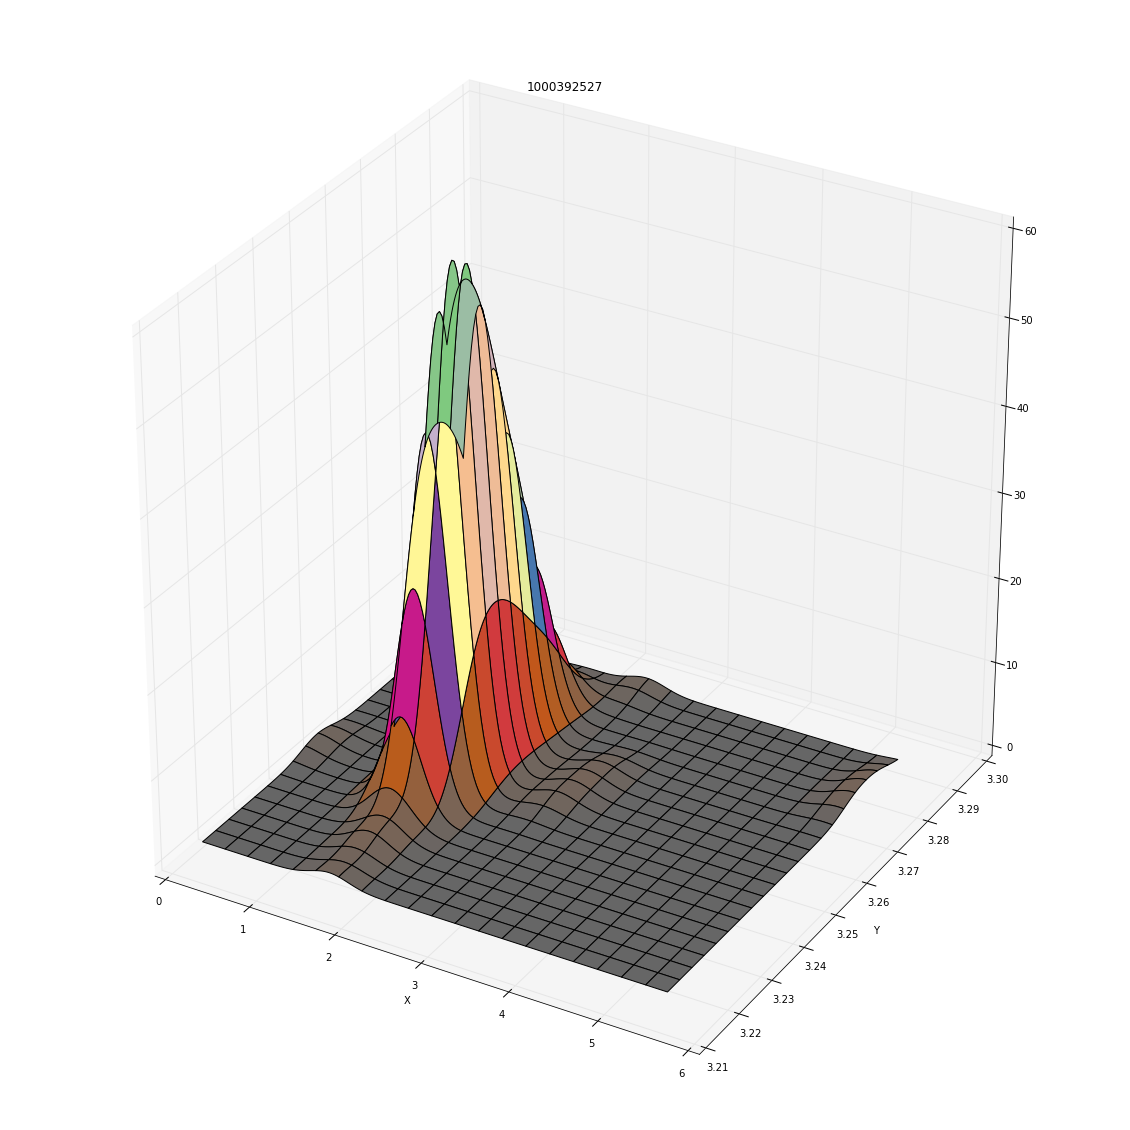

In [19]:
cmap = colormaps()[1]
fig = figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap= cmap)
ax.set_xlabel("X")
ax.set_ylabel("Y")
title(str(place_id))

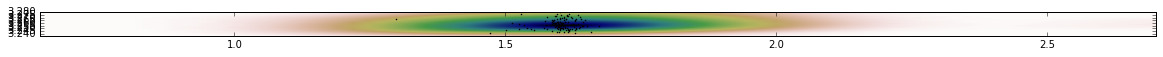

In [20]:
fig, ax = plt.subplots()
# fig.set_size_inches(18.5, 18.5)
ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
          extent=[xmin, xmax, ymin, ymax])
ax.plot(m1, m2, 'k.', markersize=2)
ax.set_xlim([values[0,:].mean()-2*values[0,:].std(), values[0,:].mean()+2*values[0,:].std()])
ax.set_ylim([values[1,:].mean()-2*values[1,:].std(), values[1,:].mean()+2*values[1,:].std()])
plt.show()

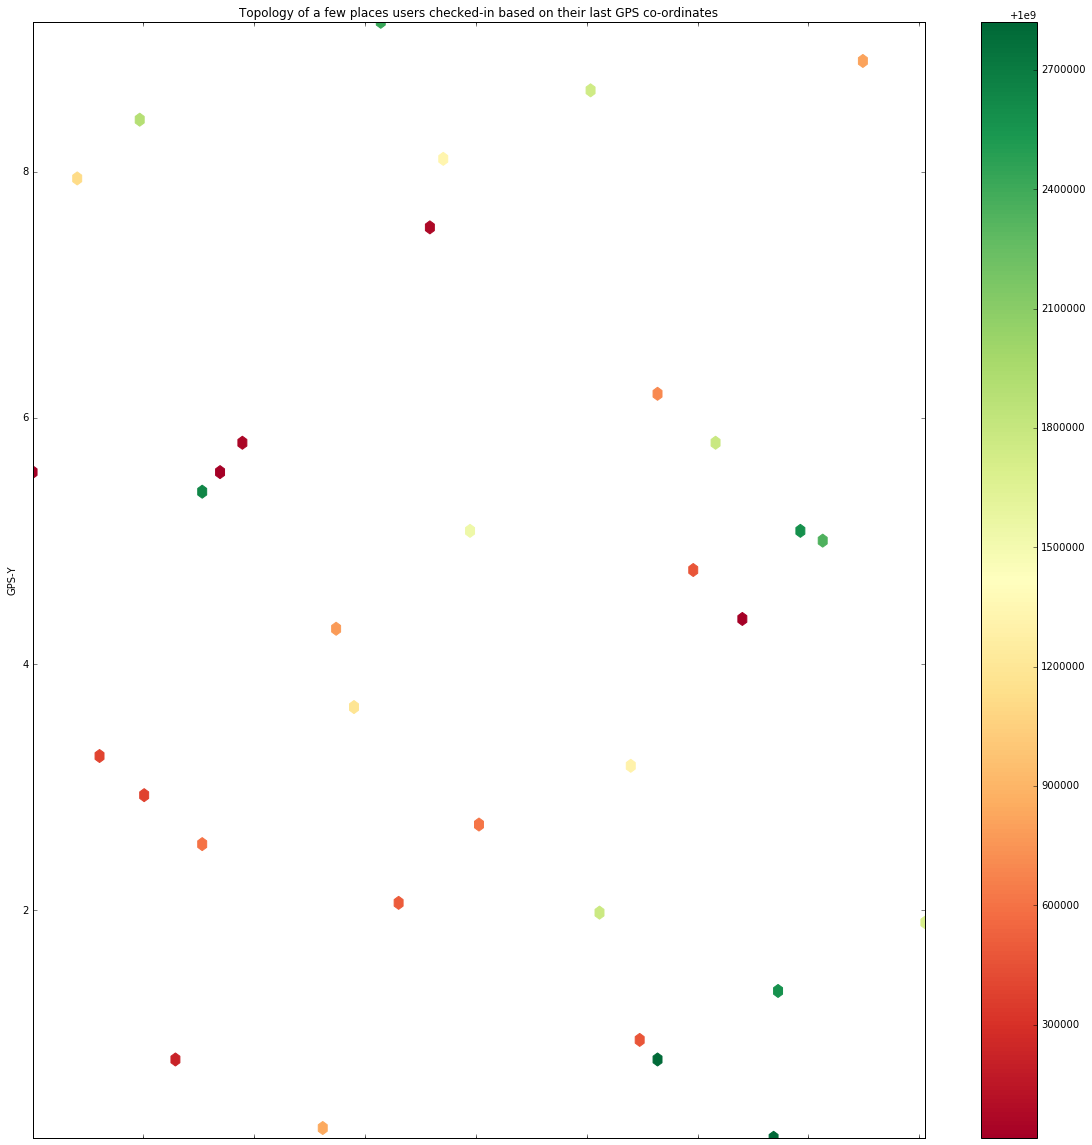

In [310]:
ax = sample_fbcheckin_train_tbl.plot(kind='hexbin', x='x', y='y', C='place_id', colormap='RdYlGn')
ax.set_xlabel("GPS-X")
ax.set_ylabel("GPS-Y")
ax.set_title("Topology of a few places users checked-in based on their last GPS co-ordinates")